# Predicting Kickstarter Project Success or Failure
This notebook builds a binary classification model to predict whether a Kickstarter project will succeed or fail.  
- **Target:** `state` (1 = Successful, 0 = Failed)  
- **Data:** `kickstarter_common.csv` (filtered for Successful/Failed projects)  
- **Approach:** Preprocess data, engineer features, train a model, and evaluate performance.

In [192]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from xgboost import XGBClassifier
import joblib

In [193]:
df = pd.read_csv('../data/kickstarter_common.csv')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(2)

Shape: (331368, 14)
Columns: ['id', 'name', 'category', 'subcategory', 'country', 'launched', 'deadline', 'goal', 'pledged', 'backers', 'state', 'duration', 'launch_month', 'launch_year']


,id,name,category,subcategory,country,launched,deadline,goal,pledged,backers,state,duration,launch_month,launch_year
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed,39,4,2009
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed,87,4,2009


In [194]:
# Encode Target
df['state_binary'] = df['state'].map({'Failed': 0, 'Successful': 1})

In [196]:
sample_input = df[-1:].drop(columns=["state_binary"])
sample_input.to_csv("../data/sample_input.csv", index=False)
sample_input

,id,name,category,subcategory,country,launched,deadline,goal,pledged,backers,state,duration,launch_month,launch_year
331367,801423615,Collaboration with Snoop Dogg,Music,Hip-Hop,Australia,2017-12-29 03:22:32,2018-01-01,392,514,6,Successful,2,12,2017


In [125]:
df.head(2)

,id,name,category,subcategory,country,launched,deadline,goal,pledged,backers,state,duration,launch_month,launch_year,state_binary
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed,39,4,2009,0
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed,87,4,2009,0


<Axes: >

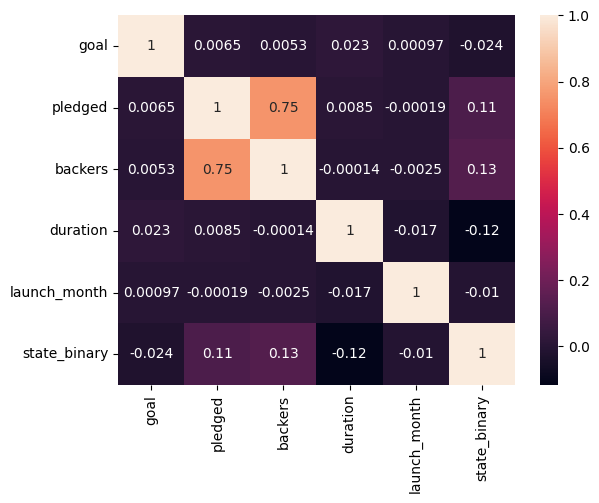

In [126]:
sns.heatmap(df[['goal', 'pledged', 'backers', 'duration', 'launch_month', 'state_binary']].corr(), annot=True)


In [127]:
df[['goal', 'backers']].describe()

,goal,backers
count,3.313680e+05,331368.000000
mean,4.119947e+04,116.485171
std,1.095625e+06,965.868090
min,1.000000e+00,0.000000
25%,2.000000e+03,2.000000
50%,5.000000e+03,15.000000
75%,1.500000e+04,63.000000
max,1.663614e+08,219382.000000


In [128]:
# Log Transform
df['log_goal'] = np.log1p(df['goal'])
df['log_backers'] = np.log1p(df['backers'])

In [182]:
df['log_goal'].describe()

count    331368.000000
mean          8.583416
std           1.666369
min           0.693147
25%           7.601402
50%           8.517393
75%           9.615872
max          18.929673
Name: log_goal, dtype: float64

In [180]:
df_model = df.drop(['id', 'name', 'launched', 'deadline', 'pledged', 'state', 'goal', 'backers', 'log_backers'], axis=1)
print(df_model.columns)

# Encoding categorical variables
df_model = pd.get_dummies(df_model, columns=['category', 'subcategory', 'country'], drop_first=True)

Index(['category', 'subcategory', 'country', 'duration', 'launch_month',
       'launch_year', 'state_binary', 'log_goal'],
      dtype='object')


In [181]:
sample_input = df_model[-1:].drop(columns=["state_binary"])
sample_input.to_csv("../data/sample_input.csv", index=False)


In [130]:
# seperate features and target variable
X = df_model.drop(['state_binary'], axis=1)
y = df_model['state_binary']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (331368, 197)
y shape: (331368,)


In [174]:
joblib.dump(list(X.columns), "../model/feature_names.pkl")

['../model/feature_names.pkl']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [175]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "../model/scaler.pkl")

['../model/scaler.pkl']

Logistic Regression

In [133]:
logistic_regression = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logistic_regression.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [134]:
y_pred_logistic_regression = logistic_regression.predict(X_test_scaled)
y_pred_proba_logistic_regression = logistic_regression.predict_proba(X_test_scaled)[:, 1]

In [135]:
# Evaluate
print("Train Set Evaluation for Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_logistic_regression))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic_regression))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic_regression))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_logistic_regression))

Train Set Evaluation for Logistic Regression:
Accuracy: 0.6569393729064188

Confusion Matrix:
[[25799 13712]
 [ 9024 17739]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.65      0.69     39511
           1       0.56      0.66      0.61     26763

    accuracy                           0.66     66274
   macro avg       0.65      0.66      0.65     66274
weighted avg       0.67      0.66      0.66     66274

ROC AUC Score: 0.718314640132913


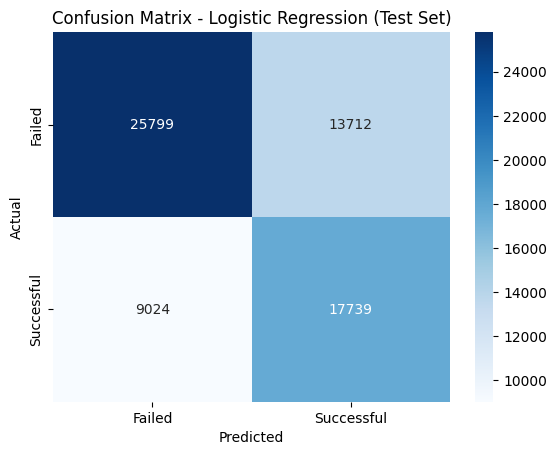

In [160]:
# Confusion matrix for logistic regression on test set
cm = confusion_matrix(y_test, y_pred_logistic_regression)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Failed', 'Successful'], yticklabels=['Failed', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (Test Set)')
plt.show()

Random Forest

In [149]:
random_forest = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5
)

random_forest.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [150]:
# Train set predictions
y_pred_train_random_forest = random_forest.predict(X_train_scaled)
y_pred_train_proba_random_forest = random_forest.predict_proba(X_train_scaled)[:, 1]

In [151]:
# Test set predictions
y_pred_test_random_forest = random_forest.predict(X_test_scaled)
y_pred_test_proba_random_forest = random_forest.predict_proba(X_test_scaled)[:, 1]

In [152]:
# Evaluate Train Set
print("Train Set Evaluation for Random Forest:")
print("\nAccuracy:", accuracy_score(y_train, y_pred_train_random_forest))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_pred_train_random_forest))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train_random_forest))
print("\nROC AUC Score:", roc_auc_score(y_train, y_pred_train_proba_random_forest))

Train Set Evaluation for Random Forest:

Accuracy: 0.6603204900903076

Confusion Matrix:
 [[106121  51921]
 [ 38126  68926]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.67      0.70    158042
           1       0.57      0.64      0.60    107052

    accuracy                           0.66    265094
   macro avg       0.65      0.66      0.65    265094
weighted avg       0.67      0.66      0.66    265094


ROC AUC Score: 0.7178215034584692


In [154]:
# Evaluate Test Set
print("Test Set Evaluation for Random Forest:")
print("\nAccuracy:", accuracy_score(y_test, y_pred_test_random_forest))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test_random_forest))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test_random_forest))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_test_proba_random_forest))

Test Set Evaluation for Random Forest:

Accuracy: 0.6563509068412953

Confusion Matrix:
 [[26333 13178]
 [ 9597 17166]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.67      0.70     39511
           1       0.57      0.64      0.60     26763

    accuracy                           0.66     66274
   macro avg       0.65      0.65      0.65     66274
weighted avg       0.67      0.66      0.66     66274


ROC AUC Score: 0.7134637086610848


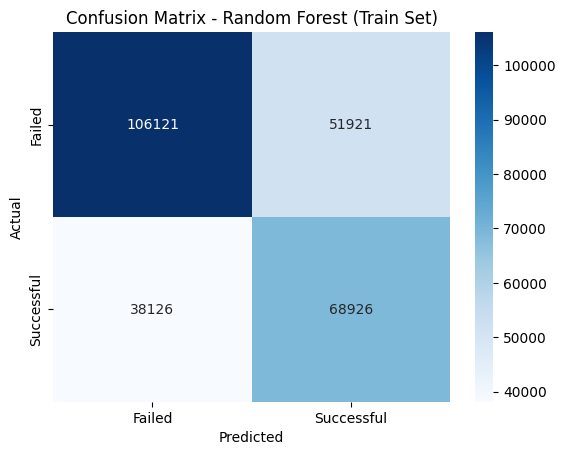

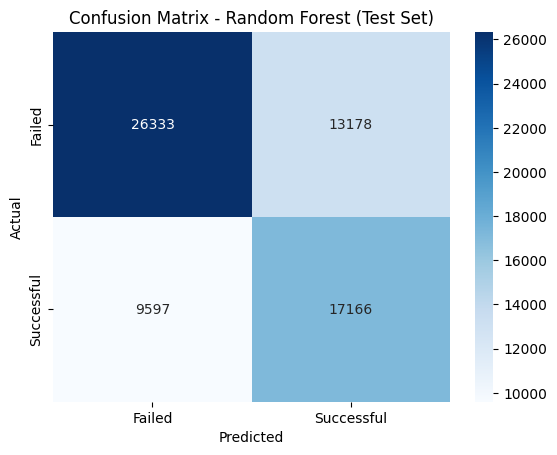

In [ ]:
# Confusion matri for random forest test set
cm = confusion_matrix(y_train, y_pred_train_random_forest)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Failed', 'Successful'], yticklabels=['Failed', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest (Train Set)')
plt.show()

# Confusion matrix for random forest train set
cm = confusion_matrix(y_test, y_pred_test_random_forest)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Failed', 'Successful'], yticklabels=['Failed', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest (Test Set)')
plt.show()

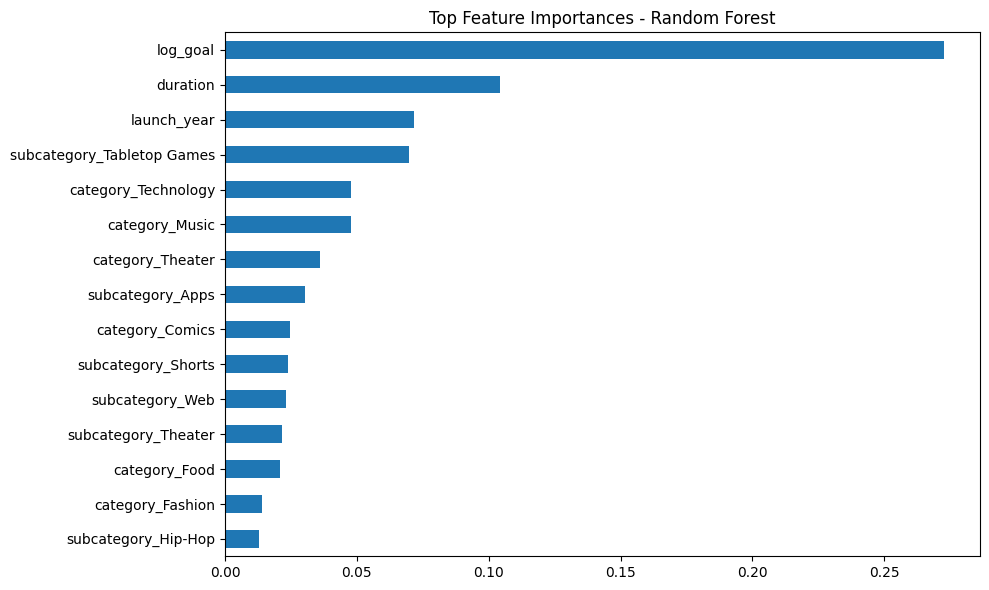

In [159]:
# Feature Importance
importances = pd.Series(random_forest.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).tail(15).plot(kind='barh', figsize=(10, 6), title='Top Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
# According to the Random Forest model
# goal amount,
# campaign duration,
# project category 
# are the most influential factors in determining whether a project will succeed on Kickstarter.

In [162]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10]
}

random_forest = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 10, 20]},
             scoring='roc_auc')

In [163]:
# Test set predictions after tuning
y_pred_test_random_forest = grid_search.predict(X_test_scaled)
y_pred_test_proba_random_forest = grid_search.predict_proba(X_test_scaled)[:, 1]

In [164]:
# Evaluate Test Set after tuning
print("Test Set Evaluation after tuning Random Forest:")
print("\nBest Params:", grid_search.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred_test_random_forest))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test_random_forest))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test_random_forest))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_test_proba_random_forest))

Test Set Evaluation after tuning Random Forest:

Best Params: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10}

Accuracy: 0.6658870748709901

Confusion Matrix:
 [[26624 12887]
 [ 9256 17507]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.67      0.71     39511
           1       0.58      0.65      0.61     26763

    accuracy                           0.67     66274
   macro avg       0.66      0.66      0.66     66274
weighted avg       0.67      0.67      0.67     66274


ROC AUC Score: 0.7263400917300575


In [177]:
joblib.dump(grid_search.best_estimator_, "../model/rf_model.pkl")

['../model/rf_model.pkl']

XGBOOST

In [166]:
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

xgb.fit(X_train_scaled, y_train)

c:\Users\devib\OneDrive\Desktop\Spiced-Academy\ml_project\punch_finisher\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [167]:
# Predict
y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]


In [168]:
print("Test Set Evaluation - XGBoost")
print("\nAccuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba_xgb))


Test Set Evaluation - XGBoost

Accuracy: 0.6872529196970154

Confusion Matrix:
 [[32237  7274]
 [13453 13310]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76     39511
           1       0.65      0.50      0.56     26763

    accuracy                           0.69     66274
   macro avg       0.68      0.66      0.66     66274
weighted avg       0.68      0.69      0.68     66274


ROC AUC Score: 0.7435516123102103
